Import the necessary libraries


In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.linalg import eigh

hb = 0.658229  # eV·fs
m0 = 5.6770736 / 100 # eV·fs²/amstrong²
me_over_hbar = m0 / hb
pi = np.pi

We first start calculating the TBM momentum matrix along with kx and ky

In [3]:
def tb_parameters(material):
    atab = np.array([3.190, 0.3191, 0.3326, 0.3325, 0.3557, 0.3560])
    e1tab = np.array([1.046, 1.130, 0.919, 0.943, 0.605, 0.606])
    e2tab = np.array([2.104, 2.275, 2.065, 2.179, 1.972, 2.102])
    t0tab = np.array([-0.184, -0.206, -0.188, -0.207, -0.169, -0.175])
    t1tab = np.array([0.401, 0.567, 0.317, 0.457, 0.228, 0.342])
    t2tab = np.array([0.507, 0.536, 0.456, 0.486, 0.390, 0.410])
    t11tab = np.array([0.218, 0.286, 0.211, 0.263, 0.207, 0.233])
    t12tab = np.array([0.338, 0.384, 0.290, 0.329, 0.239, 0.270])
    t22tab = np.array([0.057, -0.061, 0.130, 0.034, 0.252, 0.190])
    lambdatab = np.array([0.073, 0.211, 0.091, 0.228, 0.107, 0.237])

    a = atab[material - 1]
    e1 = e1tab[material - 1]
    e2 = e2tab[material - 1]
    t0 = t0tab[material - 1]
    t1 = t1tab[material - 1]
    t2 = t2tab[material - 1]
    t11 = t11tab[material - 1]
    t12 = t12tab[material - 1]
    t22 = t22tab[material - 1]
    lambda_ = lambdatab[material - 1]
    G = 4 * pi / (np.sqrt(3) * a)

    return a, e1, e2, t0, t1, t2, t11, t12, t22, lambda_, G

def kgrid(nk, G, a):
    dk = (4 * pi / a) / (nk - 1)
    akx = np.zeros((nk, nk))
    aky = np.zeros((nk, nk))

    for j in range(nk):
        for i in range(nk):
            akx[i, j] = - 2 * pi / a + i * dk
            aky[i, j] = - 2 * pi / a + j * dk

    return akx, aky

def tb_ham(kx, ky, params):
    a, e1, e2, t0, t1, t2, t11, t12, t22, lambda_, G = params

    alpha = kx * a / 2
    beta = np.sqrt(3) * ky * a / 2

    er0 = np.array([[e1, 0, 0], [0, e2, 0], [0, 0, e2]])
    er1 = np.array([[t0, t1, t2], [-t1, t11, t12], [t2, -t12, t22]])

    er2 = np.array([[t0, t1 / 2 - np.sqrt(3) * t2 / 2, -np.sqrt(3) * t1 / 2 - t2 / 2],
                    [-t1 / 2 - np.sqrt(3) * t2 / 2, t11 / 4 + 3 * t22 / 4, -np.sqrt(3) * t11 / 4 - t12 + np.sqrt(3) * t22 / 4],
                    [np.sqrt(3) * t1 / 2 - t2 / 2, -np.sqrt(3) * t11 / 4 + t12 + np.sqrt(3) * t22 / 4, 3 * t11 / 4 + t22 / 4]])

    er3 = np.array([[t0, -t1 / 2 + np.sqrt(3) * t2 / 2, -np.sqrt(3) * t1 / 2 - t2 / 2],
                    [t1 / 2 + np.sqrt(3) * t2 / 2, t11 / 4 + 3 * t22 / 4, np.sqrt(3) * t11 / 4 + t12 - np.sqrt(3) * t22 / 4],
                    [np.sqrt(3) * t1 / 2 - t2 / 2, np.sqrt(3) * t11 / 4 - t12 - np.sqrt(3) * t22 / 4, 3 * t11 / 4 + t22 / 4]])

    er4 = np.array([[t0, -t1, t2], [t1, t11, -t12], [t2, t12, t22]])

    er5 = np.array([[t0, -t1 / 2 - np.sqrt(3) * t2 / 2, np.sqrt(3) * t1 / 2 - t2 / 2],
                    [t1 / 2 - np.sqrt(3) * t2 / 2, t11 / 4 + 3 * t22 / 4, -np.sqrt(3) * t11 / 4 + t12 + np.sqrt(3) * t22 / 4],
                    [-np.sqrt(3) * t1 / 2 - t2 / 2, -np.sqrt(3) * t11 / 4 - t12 + np.sqrt(3) * t22 / 4, 3 * t11 / 4 + t22 / 4]])

    er6 = np.array([[t0, t1 / 2 + np.sqrt(3) * t2 / 2, np.sqrt(3) * t1 / 2 - t2 / 2],
                    [-t1 / 2 + np.sqrt(3) * t2 / 2, t11 / 4 + 3 * t22 / 4, np.sqrt(3) * t11 / 4 - t12 - np.sqrt(3) * t22 / 4],
                    [-np.sqrt(3) * t1 / 2 - t2 / 2, np.sqrt(3) * t11 / 4 + t12 - np.sqrt(3) * t22 / 4, 3 * t11 / 4 + t22 / 4]])


    ham = er0 + np.exp(1j * 2 * alpha) * er1 + np.exp(1j * (alpha - beta)) * er2 + np.exp(1j * (-alpha - beta)) * er3 + np.exp(-1j * 2 * alpha) * er4 + np.exp(1j * (-alpha + beta)) * er5 + np.exp(1j * (alpha + beta)) * er6

    dhkx = (1j * a * np.exp(1j * 2 * alpha) * er1 + 1j * a / 2 * np.exp(1j * (alpha - beta)) * er2
                - 1j * a / 2 * np.exp(1j * (-alpha - beta)) * er3 - 1j * a * np.exp(-1j * 2 * alpha) * er4
                - 1j * a / 2 * np.exp(1j * (-alpha + beta)) * er5 + 1j * a / 2 * np.exp(1j * (alpha + beta)) * er6)

    dhky = (-1j * np.sqrt(3) * a / 2 * np.exp(1j * (alpha - beta)) * er2 - 1j * np.sqrt(3) * a / 2 * np.exp(1j * (-alpha - beta)) * er3
                + 1j * np.sqrt(3) * a / 2 * np.exp(1j * (-alpha + beta)) * er5 + 1j * np.sqrt(3) * a / 2 * np.exp(1j * (alpha + beta)) * er6)

    Lz = np.array([[0, 0, 0], [0, 0, 2j], [0, -2j, 0]], dtype=np.complex128)

    hamu = ham + lambda_ / 2 * Lz
    hamd = ham - lambda_ / 2 * Lz

    return ham, hamu, hamd, dhkx, dhky

def initialize_band_data(nk):
    bandu = np.zeros((3, nk, nk))
    bandd = np.zeros((3, nk, nk))
    band = np.zeros((3, nk, nk))
    pmx = np.zeros((3, 3, nk, nk), dtype=complex)
    pmy = np.zeros((3, 3, nk, nk), dtype=complex)
    vecs_save = np.zeros((3, 3, nk, nk), dtype=complex)

    return bandu, bandd, band, pmx, pmy, vecs_save

def initialize_matrices():
    ham = np.zeros((3, 3), dtype=complex)
    hamu = np.zeros((3, 3), dtype=complex)
    hamd = np.zeros((3, 3), dtype=complex)
    dhkx = np.zeros((3, 3), dtype=complex)
    dhky = np.zeros((3, 3), dtype=complex)

    return ham, hamu, hamd, dhkx, dhky

def bandstructure(nk, akx, aky, a, e1, e2, t0, t1, t2, t11, t12, t22, lambda_, G):

    bandu, bandd, band, pmx, pmy, vecs_save = initialize_band_data(nk)

    for j in tqdm(range(nk)):
        for i in range(nk):
            kx, ky = akx[i, j], aky[i, j]

            ham, hamu, hamd, dhkx, dhky = initialize_matrices()
            ham, hamu, hamd, dhkx, dhky = tb_ham(kx, ky, (a, e1, e2, t0, t1, t2, t11, t12, t22, lambda_, G))

            vals, vecs = eigh(ham)
            band[:, i, j] = vals
            vecs_save[:, :, i, j] = vecs

            for jb in range(3):  # λ'
                for ib in range(3):  #  λ
                    sum1 = 0. + 0j   #  kx
                    sum2 = 0. + 0j   #  ky
                    for jjb in range(3): # j'
                        for iib in range(3): # j
                            sum1 += np.conjugate(vecs[iib, ib]) * dhkx[iib, jjb] * vecs[jjb, jb]
                            sum2 += np.conjugate(vecs[iib, ib]) * dhky[iib, jjb] * vecs[jjb, jb]
                    pmx[ib, jb, i, j] = sum1 * m0 / hb
                    pmy[ib, jb, i, j] = sum2 * m0 / hb

            bandu[:, i, j] = eigh(hamu, eigvals_only=True)

            bandd[:, i, j] = eigh(hamd, eigvals_only=True)

    return bandu, bandd, band, pmx, pmy, vecs_save

def save_data(nk, G, akx, aky, bandu, bandd, band, pmx, pmy, a, vecs_save):
    with open("new vecs_tb with kx ky.txt", "w") as f:
            # Ghi header
        f.write("kx ky Re(v0_1) Im(v0_1) Re(v0_2) Im(v0_2) Re(v0_3) Im(v0_3) ")
        f.write("Re(v1_1) Im(v1_1) Re(v1_2) Im(v1_2) Re(v1_3) Im(v1_3)\n")
        for j in range(nk):
            for i in range(nk):
                kx = akx[i, j] / (2 * np.pi / a)
                ky = aky[i, j] / (2 * np.pi / a)

                vec0 = vecs_save[:, 0, i, j]
                vec1 = vecs_save[:, 1, i, j]
                line_data = [kx, ky]
                for v in vec0:
                    line_data.extend([v.real, v.imag])
                for v in vec1:
                    line_data.extend([v.real, v.imag])

                f.write(" ".join(f"{x:.6e}" for x in line_data) + "\n")


    with open("bandstr1 cho tb with kx ky.txt", "w") as f:
        for i in range(nk):
            kx = -np.sqrt(3) * G / 2 + (i) * np.sqrt(3) * G / (nk - 1)  #
            f.write(f"{kx / (2 * np.pi / a)} {band[0, i, 0]} {band[1, i, 0]} {band[2, i, 0]}\n")

    with open("bandstr2 cho tb with kx ky.txt", "w") as f:
        f.write("#kx ky band1 band2 band3 \n")
        for j in range(nk):
            for i in range(nk):
                f.write(f"{akx[i, j] / (2 * np.pi / a)} {aky[i, j] / (2 * np.pi / a)} "
                        f"{band[0, i, j]} {band[1, i, j]} {band[2, i, j]}\n")
            f.write("\n")

    with open("momentum cho tb val_cond with kx ky.txt", "w") as f:
        f.write(f"#{'kx':^12} {'ky':^12}  {'px':^25} {'py':^25} {'|pp|':^12} {'|pm|':^12} {'|p|':^25} \n")
        for j in range(nk):
            for i in range(nk):
                px, py = pmx[0, 1, i, j], pmy[0, 1, i, j]
                p = np.sqrt((abs(px))**2 + (abs(py))**2)
                pp = px + 1j * py
                pm = px - 1j * py
                kx = akx[i, j] / (2 * np.pi / a)
                ky = aky[i, j] / (2 * np.pi / a)

                f.write(f"{kx:.6e} {ky:.6e} ({px.real:.6e},{px.imag:.6e}) ({py.real:.6e},{py.imag:.6e}) "
                        f"{abs(pp):.6e} {abs(pm):.6e} {p:.6e} \n")

            f.write("\n")

    with open("momentum cho tb cond_val with kx ky.txt", "w") as f:
            f.write(f"#{'kx':^12} {'ky':^12}  {'px':^25} {'py':^25} {'|pp|':^12} {'|pm|':^12} {'|p|':^25} \n")
            for j in range(nk):
                for i in range(nk):
                    px, py = pmx[1, 0, i, j], pmy[1, 0, i, j]
                    p = np.sqrt((abs(px))**2 + (abs(py))**2)
                    pp = px + 1j * py
                    pm = px - 1j * py
                    kx = akx[i, j] / (2 * np.pi / a)
                    ky = aky[i, j] / (2 * np.pi / a)

                    f.write(f"{kx:.6e} {ky:.6e} ({px.real:.6e},{px.imag:.6e}) ({py.real:.6e},{py.imag:.6e}) "
                            f"{abs(pp):.6e} {abs(pm):.6e} {p:.6e} \n")

                f.write("\n")


def main():
    nk = 299
    material = 1  # MoS2

    a, e1, e2, t0, t1, t2, t11, t12, t22, lambda_, G = tb_parameters(material)
    akx, aky = kgrid(nk, G, a)
    bandu, bandd, band, pmx, pmy, vecs_save = bandstructure(nk, akx, aky, a, e1, e2, t0, t1, t2, t11, t12, t22, lambda_, material)

    save_data(nk, G, akx, aky, bandu, bandd, band, pmx, pmy, a, vecs_save)
    print("Hoàn tất tính toán dải năng lượng!")

if __name__ == "__main__":
    main()

100%|██████████| 299/299 [00:35<00:00,  8.52it/s]


Hoàn tất tính toán dải năng lượng!


In [4]:
def tb_parameters(material):
    atab = np.array([3.190, 0.3191, 0.3326, 0.3325, 0.3557, 0.3560])
    e1tab = np.array([1.046, 1.130, 0.919, 0.943, 0.605, 0.606])
    e2tab = np.array([2.104, 2.275, 2.065, 2.179, 1.972, 2.102])
    t0tab = np.array([-0.184, -0.206, -0.188, -0.207, -0.169, -0.175])
    t1tab = np.array([0.401, 0.567, 0.317, 0.457, 0.228, 0.342])
    t2tab = np.array([0.507, 0.536, 0.456, 0.486, 0.390, 0.410])
    t11tab = np.array([0.218, 0.286, 0.211, 0.263, 0.207, 0.233])
    t12tab = np.array([0.338, 0.384, 0.290, 0.329, 0.239, 0.270])
    t22tab = np.array([0.057, -0.061, 0.130, 0.034, 0.252, 0.190])
    lambdatab = np.array([0.073, 0.211, 0.091, 0.228, 0.107, 0.237])

    a = atab[material - 1]
    e1 = e1tab[material - 1]
    e2 = e2tab[material - 1]
    t0 = t0tab[material - 1]
    t1 = t1tab[material - 1]
    t2 = t2tab[material - 1]
    t11 = t11tab[material - 1]
    t12 = t12tab[material - 1]
    t22 = t22tab[material - 1]
    lambda_ = lambdatab[material - 1]
    G = 4 * pi / (np.sqrt(3) * a)

    return a, e1, e2, t0, t1, t2, t11, t12, t22, lambda_, G

def kgrid(nk, G, a):
    dk = (4 * pi / a) / (nk - 1)
    akx = np.zeros((nk, nk))
    aky = np.zeros((nk, nk))

    for j in range(nk):
        for i in range(nk):
            akx[i, j] = - 2 * pi / a + i * dk
            aky[i, j] = 0

    return akx, aky

def tb_ham(kx, ky, params):
    a, e1, e2, t0, t1, t2, t11, t12, t22, lambda_, G = params

    alpha = kx * a / 2
    beta = np.sqrt(3) * ky * a / 2

    er0 = np.array([[e1, 0, 0], [0, e2, 0], [0, 0, e2]])
    er1 = np.array([[t0, t1, t2], [-t1, t11, t12], [t2, -t12, t22]])

    er2 = np.array([[t0, t1 / 2 - np.sqrt(3) * t2 / 2, -np.sqrt(3) * t1 / 2 - t2 / 2],
                    [-t1 / 2 - np.sqrt(3) * t2 / 2, t11 / 4 + 3 * t22 / 4, -np.sqrt(3) * t11 / 4 - t12 + np.sqrt(3) * t22 / 4],
                    [np.sqrt(3) * t1 / 2 - t2 / 2, -np.sqrt(3) * t11 / 4 + t12 + np.sqrt(3) * t22 / 4, 3 * t11 / 4 + t22 / 4]])

    er3 = np.array([[t0, -t1 / 2 + np.sqrt(3) * t2 / 2, -np.sqrt(3) * t1 / 2 - t2 / 2],
                    [t1 / 2 + np.sqrt(3) * t2 / 2, t11 / 4 + 3 * t22 / 4, np.sqrt(3) * t11 / 4 + t12 - np.sqrt(3) * t22 / 4],
                    [np.sqrt(3) * t1 / 2 - t2 / 2, np.sqrt(3) * t11 / 4 - t12 - np.sqrt(3) * t22 / 4, 3 * t11 / 4 + t22 / 4]])

    er4 = np.array([[t0, -t1, t2], [t1, t11, -t12], [t2, t12, t22]])

    er5 = np.array([[t0, -t1 / 2 - np.sqrt(3) * t2 / 2, np.sqrt(3) * t1 / 2 - t2 / 2],
                    [t1 / 2 - np.sqrt(3) * t2 / 2, t11 / 4 + 3 * t22 / 4, -np.sqrt(3) * t11 / 4 + t12 + np.sqrt(3) * t22 / 4],
                    [-np.sqrt(3) * t1 / 2 - t2 / 2, -np.sqrt(3) * t11 / 4 - t12 + np.sqrt(3) * t22 / 4, 3 * t11 / 4 + t22 / 4]])

    er6 = np.array([[t0, t1 / 2 + np.sqrt(3) * t2 / 2, np.sqrt(3) * t1 / 2 - t2 / 2],
                    [-t1 / 2 + np.sqrt(3) * t2 / 2, t11 / 4 + 3 * t22 / 4, np.sqrt(3) * t11 / 4 - t12 - np.sqrt(3) * t22 / 4],
                    [-np.sqrt(3) * t1 / 2 - t2 / 2, np.sqrt(3) * t11 / 4 + t12 - np.sqrt(3) * t22 / 4, 3 * t11 / 4 + t22 / 4]])


    ham = er0 + np.exp(1j * 2 * alpha) * er1 + np.exp(1j * (alpha - beta)) * er2 + np.exp(1j * (-alpha - beta)) * er3 + np.exp(-1j * 2 * alpha) * er4 + np.exp(1j * (-alpha + beta)) * er5 + np.exp(1j * (alpha + beta)) * er6

    dhkx = (1j * a * np.exp(1j * 2 * alpha) * er1 + 1j * a / 2 * np.exp(1j * (alpha - beta)) * er2
                - 1j * a / 2 * np.exp(1j * (-alpha - beta)) * er3 - 1j * a * np.exp(-1j * 2 * alpha) * er4
                - 1j * a / 2 * np.exp(1j * (-alpha + beta)) * er5 + 1j * a / 2 * np.exp(1j * (alpha + beta)) * er6)

    dhky = (-1j * np.sqrt(3) * a / 2 * np.exp(1j * (alpha - beta)) * er2 - 1j * np.sqrt(3) * a / 2 * np.exp(1j * (-alpha - beta)) * er3
                + 1j * np.sqrt(3) * a / 2 * np.exp(1j * (-alpha + beta)) * er5 + 1j * np.sqrt(3) * a / 2 * np.exp(1j * (alpha + beta)) * er6)

    Lz = np.array([[0, 0, 0], [0, 0, 2j], [0, -2j, 0]], dtype=np.complex128)

    hamu = ham + lambda_ / 2 * Lz
    hamd = ham - lambda_ / 2 * Lz

    return ham, hamu, hamd, dhkx, dhky

def initialize_band_data(nk):
    bandu = np.zeros((3, nk, nk))
    bandd = np.zeros((3, nk, nk))
    band = np.zeros((3, nk, nk))
    pmx = np.zeros((3, 3, nk, nk), dtype=complex)
    pmy = np.zeros((3, 3, nk, nk), dtype=complex)
    vecs_save = np.zeros((3, 3, nk, nk), dtype=complex)

    return bandu, bandd, band, pmx, pmy, vecs_save

def initialize_matrices():
    ham = np.zeros((3, 3), dtype=complex)
    hamu = np.zeros((3, 3), dtype=complex)
    hamd = np.zeros((3, 3), dtype=complex)
    dhkx = np.zeros((3, 3), dtype=complex)
    dhky = np.zeros((3, 3), dtype=complex)

    return ham, hamu, hamd, dhkx, dhky

def bandstructure(nk, akx, aky, a, e1, e2, t0, t1, t2, t11, t12, t22, lambda_, G):

    bandu, bandd, band, pmx, pmy, vecs_save = initialize_band_data(nk)

    for j in tqdm(range(nk)):
        for i in range(nk):
            kx, ky = akx[i, j], aky[i, j]

            ham, hamu, hamd, dhkx, dhky = initialize_matrices()
            ham, hamu, hamd, dhkx, dhky = tb_ham(kx, ky, (a, e1, e2, t0, t1, t2, t11, t12, t22, lambda_, G))

            vals, vecs = eigh(ham)
            band[:, i, j] = vals
            vecs_save[:, :, i, j] = vecs

            for jb in range(3):  # λ'
                for ib in range(3):  #  λ
                    sum1 = 0. + 0j   #  kx
                    sum2 = 0. + 0j   #  ky
                    for jjb in range(3): # j'
                        for iib in range(3): # j
                            sum1 += np.conjugate(vecs[iib, ib]) * dhkx[iib, jjb] * vecs[jjb, jb]
                            sum2 += np.conjugate(vecs[iib, ib]) * dhky[iib, jjb] * vecs[jjb, jb]
                    pmx[ib, jb, i, j] = sum1 * m0 / hb
                    pmy[ib, jb, i, j] = sum2 * m0 / hb

            bandu[:, i, j] = eigh(hamu, eigvals_only=True)

            bandd[:, i, j] = eigh(hamd, eigvals_only=True)

    return bandu, bandd, band, pmx, pmy, vecs_save

def save_data(nk, G, akx, aky, bandu, bandd, band, pmx, pmy, a, vecs_save):
    with open("new vecs_tb with kx.txt", "w") as f:
        f.write("kx ky Re(v0_1) Im(v0_1) Re(v0_2) Im(v0_2) Re(v0_3) Im(v0_3) ")
        f.write("Re(v1_1) Im(v1_1) Re(v1_2) Im(v1_2) Re(v1_3) Im(v1_3)\n")

        j = 0  # ky cố định
        for i in range(nk):
            kx = akx[i, j] / (2 * np.pi / a)
            ky = 0.0  # ky giữ cố định bằng 0

            # Vector của band 0 và 1
            vec0 = vecs_save[:, 0, i, j]  # band 0 (valence)
            vec1 = vecs_save[:, 1, i, j]  # band 1 (conduction)

            # Ghi 1 dòng gồm: kx, ky, Re+Im of vec0 (3 thành phần), Re+Im of vec1 (3 thành phần)
            line_data = [kx, ky]
            for v in vec0:
                line_data.extend([v.real, v.imag])
            for v in vec1:
                line_data.extend([v.real, v.imag])

            # Ghi dòng ra file với định dạng nhất quán
            f.write(" ".join(f"{x:.6e}" for x in line_data) + "\n")


    with open("bandstr1 cho tb with kx.txt", "w") as f:
        for i in range(nk):
            kx = -np.sqrt(3) * G / 2 + (i) * np.sqrt(3) * G / (nk - 1)  #
            f.write(f"{kx / (2 * np.pi / a)} {band[0, i, 0]} {band[1, i, 0]} {band[2, i, 0]}\n")

    with open("momentum cho tb val_cond with kx.txt", "w") as f:
        f.write(f"#{'kx':^12} {'ky':^12}  {'px':^25} {'py':^25} {'|pp|':^12} {'|pm|':^12} {'|p|':^25} \n")
        j = 0  # giả sử ky cố định tại j = 0
        for i in range(nk):
            px, py = pmx[0, 1, i, j], pmy[0, 1, i, j]
            p = np.sqrt((abs(px))**2 + (abs(py))**2)
            pp = px + 1j * py
            pm = px - 1j * py
            kx = akx[i, j] / (2 * np.pi / a)
            ky = 0.0  # ky cố định

            f.write(f"{kx:.6e} {ky:.6e} ({px.real:.6e},{px.imag:.6e}) ({py.real:.6e},{py.imag:.6e}) "
                    f"{abs(pp):.6e} {abs(pm):.6e} {p:.6e} \n")

    with open("momentum cho tb cond_val with kx.txt", "w") as f:
        f.write(f"#{'kx':^12} {'ky':^12}  {'px':^25} {'py':^25} {'|pp|':^12} {'|pm|':^12} {'|p|':^25} \n")
        j = 0  # giả sử ky cố định tại j = 0
        for i in range(nk):
            px, py = pmx[1, 0, i, j], pmy[1, 0, i, j]
            p = np.sqrt((abs(px))**2 + (abs(py))**2)
            pp = px + 1j * py
            pm = px - 1j * py
            kx = akx[i, j] / (2 * np.pi / a)
            ky = 0.0  # ky cố định

            f.write(f"{kx:.6e} {ky:.6e} ({px.real:.6e},{px.imag:.6e}) ({py.real:.6e},{py.imag:.6e}) "
                    f"{abs(pp):.6e} {abs(pm):.6e} {p:.6e} \n")

def main():
    nk = 299
    material = 1  # MoS2

    a, e1, e2, t0, t1, t2, t11, t12, t22, lambda_, G = tb_parameters(material)
    akx, aky = kgrid(nk, G, a)
    bandu, bandd, band, pmx, pmy, vecs_save = bandstructure(nk, akx, aky, a, e1, e2, t0, t1, t2, t11, t12, t22, lambda_, material)

    save_data(nk, G, akx, aky, bandu, bandd, band, pmx, pmy, a, vecs_save)
    print("Hoàn tất tính toán dải năng lượng!")

if __name__ == "__main__":
    main()

100%|██████████| 299/299 [00:38<00:00,  7.80it/s]

Hoàn tất tính toán dải năng lượng!


Suppose we got a momentum file from DFT, uploaded to the colab folder then run it.

When fitting the parameters dx & dy, we only care about a small region around K valley, so we can use a small range of kx and ky values.



dx = (3.055488819353132-7.89565929834808e-06j)
dy = (3.3834749178516157-9.879775139177633e-06j)

Calculated Δpx:
 240    0.350355-0.000001j
241    0.342134-0.000001j
242   -0.334743+0.000001j
243    0.328235-0.000001j
244    0.322653-0.000001j
245   -0.318034+0.000001j
246   -0.314404+0.000001j
247   -0.311780+0.000001j
248    0.310166-0.000001j
249    0.309553-0.000001j
250   -0.309921+0.000001j
251    0.311236-0.000001j
252    0.313457-0.000001j
253    0.316532-0.000001j
254    0.320400-0.000001j
255    0.324999-0.000001j
256   -0.330259+0.000001j
257    0.336112-0.000001j
dtype: complex128

Calculated Δpy:
 240    0.000001+0.328306j
241    0.000001+0.330907j
242   -0.000001-0.333279j
243    0.000001+0.335424j
244    0.000001+0.337344j
245   -0.000001-0.339041j
246   -0.000001-0.340516j
247   -0.000001-0.341773j
248    0.000001+0.342813j
249    0.000001+0.343639j
250   -0.000001-0.344253j
251    0.000001+0.344658j
252    0.000001+0.344856j
253    0.000001+0.344848j
254    0.000001+0

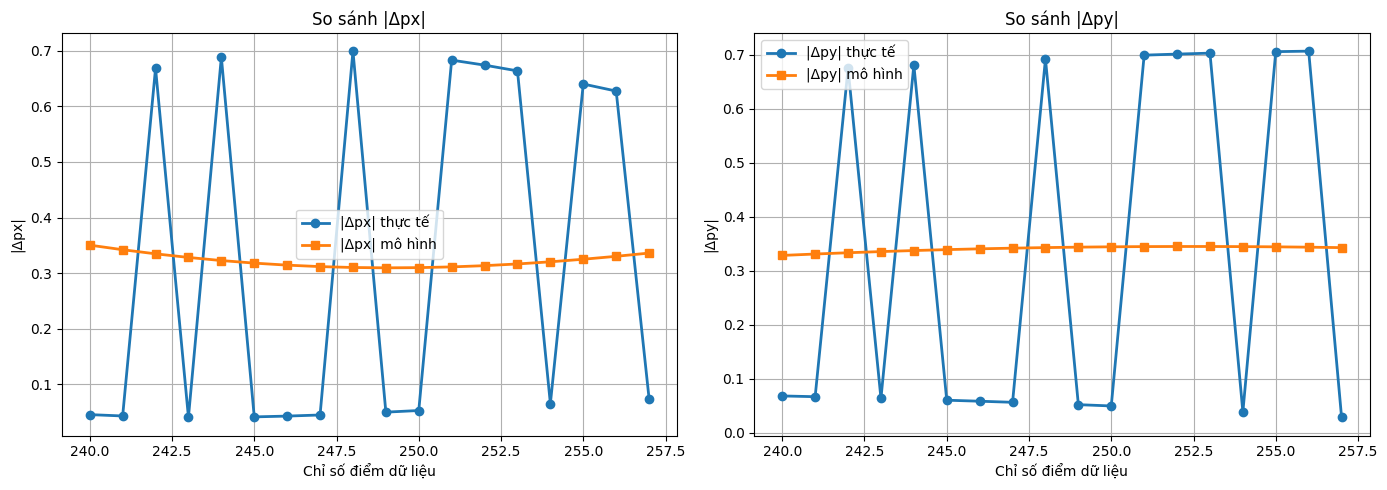

In [6]:
#df = pd.read_csv("p_cv_full_294.csv")
#df.to_csv("p_cv_full_294.txt", sep=" ", index=False)

df_dft = pd.read_csv("p_cv_abs_294.txt", skiprows=1, sep='\s+', header=None)
df_tbm = pd.read_csv("momentum cho tb val_cond with kx.txt", skiprows=1, sep='\s+', header=None)
# DFT: kiểu '(-0.4136+0.0033j)'
def str_to_complex_dft(s):
    try:
        return complex(s)
    except:
        return complex(0.0, 0.0)

# TBM: kiểu '(real,imag)'
def str_to_complex_tbm(s):
    try:
        s = s.strip('()')
        real, imag = s.split(',')
        return complex(float(real), float(imag))
    except:
        return complex(0.0, 0.0)

subset_dft = df_dft.iloc[240:258].copy()
#print("Subset DFT:\n", subset_dft)
subset_tbm = df_tbm.iloc[240:258].copy()
#print("Subset TBM:\n", subset_tbm)

# Đổi kiểu px, py trong DFT
subset_dft['px'] = subset_dft[2].apply(str_to_complex_dft)
subset_dft['py'] = subset_dft[3].apply(str_to_complex_dft)
#print("Subset DFT with px, py:\n", subset_dft[['px', 'py']])

# Đổi kiểu px, py trong TBM
subset_tbm['px'] = subset_tbm[2].apply(str_to_complex_tbm)
subset_tbm['py'] = subset_tbm[3].apply(str_to_complex_tbm)
#print("Subset TBM with px, py:\n", subset_tbm[['px', 'py']])

delta_px = subset_dft['px'] - subset_tbm['px']
delta_py = subset_dft['py'] - subset_tbm['py']
"""print("Δpx:\n", delta_px)
print()
print("Δpy:\n", delta_py)
print()"""

energy_tbm = pd.read_csv('bandstr1 cho tb with kx.txt', sep='\s+', header=None)
subset_energy_tbm = energy_tbm.iloc[240:258, [0, 1, 2]]
subset_energy_tbm.columns = ['kx', 'E_val', 'E_cond']
#print("Subset Energy TBM:\n", subset_energy_tbm)
delta_E = subset_energy_tbm['E_val'] - subset_energy_tbm['E_cond']
#print("ΔE:\n", delta_E)

data_eigvec = pd.read_csv("new vecs_tb with kx.txt", sep='\s+')
data_eigvec = data_eigvec.astype(float)
subset_eigvec = data_eigvec.iloc[240:258, :14]
subset_eigvec.columns = [
    'kx', 'ky',
    'C0_1_real', 'C0_1_imag',
    'C0_2_real', 'C0_2_imag',
    'C0_3_real', 'C0_3_imag',
    'C1_1_real', 'C1_1_imag',
    'C1_2_real', 'C1_2_imag',
    'C1_3_real', 'C1_3_imag'
]
#print("Subset Eigenvectors:\n", subset_eigvec)
C0_1 = subset_eigvec['C0_1_real'].values + 1j * subset_eigvec['C0_1_imag'].values
C0_2 = subset_eigvec['C0_2_real'].values + 1j * subset_eigvec['C0_2_imag'].values
C0_3 = subset_eigvec['C0_3_real'].values + 1j * subset_eigvec['C0_3_imag'].values

C1_1 = subset_eigvec['C1_1_real'].values + 1j * subset_eigvec['C1_1_imag'].values
C1_2 = subset_eigvec['C1_2_real'].values + 1j * subset_eigvec['C1_2_imag'].values
C1_3 = subset_eigvec['C1_3_real'].values + 1j * subset_eigvec['C1_3_imag'].values

"""print("C0_1:", C0_1)
print("C0_2:", C0_2)
print("C0_3:", C0_3)
print("C1_1:", C1_1)
print("C1_2:", C1_2)
print("C1_3:", C1_3)"""

Delta_Cx = 1j * (m0/hb) * delta_E * (np.conj(C0_1) * C1_2 + np.conj(C0_2) * C1_1)
Delta_Cy = 1j * (m0/hb) * delta_E * (np.conj(C0_1) * C1_3 + np.conj(C0_3) * C1_1)

"""print("Delta_Cx:\n", Delta_Cx)
print()
print("Delta_Cy:\n", Delta_Cy)"""

# Complex inner product regression
def complex_regression(X, Y):
    numerator = np.vdot(X, Y)  # ∑ X_i* · Y_i
    denominator = np.vdot(X, X)  # ∑ X_i* · X_i
    return numerator / denominator

dx = complex_regression(Delta_Cx, delta_px)
dy = complex_regression(Delta_Cy, delta_py)
#dx = -3.177953107
#dy = dx


print()
print("dx =", dx)
print("dy =", dy)
print()

calculated_delta_px = dx * Delta_Cx
calculated_delta_py = dy * Delta_Cy

print("Calculated Δpx:\n", calculated_delta_px)
print()
print("Calculated Δpy:\n", calculated_delta_py)


# Tạo bảng so sánh cho delta_px
df_px = pd.DataFrame({
    'px (DFT)': subset_dft['px'],
    'px (TBM)': subset_tbm['px'] + calculated_delta_px,
    'Sai số tuyệt đối': np.abs(subset_dft['px'] - (subset_tbm['px'] + calculated_delta_px))
})

# Tạo bảng so sánh cho delta_py
df_py = pd.DataFrame({
    'py (DFT)': subset_dft['py'],
    'py (TBM)': subset_tbm['py'] + calculated_delta_py,
    'Sai số tuyệt đối': np.abs(subset_dft['py'] - (subset_tbm['py'] + calculated_delta_py))
})
"""print("🟦 So sánh Δpx:")
print(df_px, "\n")

print("🟩 So sánh Δpy:")
print(df_py)"""

# Tính mô đun
abs_delta_px_real = np.abs(delta_px)
abs_calc_delta_px_real = np.abs(calculated_delta_px)

abs_delta_py_real = np.abs(delta_py)
abs_calc_delta_py_real = np.abs(calculated_delta_py)

# === Vẽ cả hai trong cùng một figure
fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # 1 hàng, 2 cột

# --- Δpx ---
axs[0].plot(abs_delta_px_real, marker='o', label='|Δpx| thực tế', linewidth=2)
axs[0].plot(abs_calc_delta_px_real, marker='s', label='|Δpx| mô hình', linewidth=2)
axs[0].set_title('So sánh |Δpx|')
axs[0].set_xlabel('Chỉ số điểm dữ liệu')
axs[0].set_ylabel('|Δpx|')
axs[0].legend()
axs[0].grid(True)

# --- Δpy ---
axs[1].plot(abs_delta_py_real, marker='o', label='|Δpy| thực tế', linewidth=2)
axs[1].plot(abs_calc_delta_py_real, marker='s', label='|Δpy| mô hình', linewidth=2)
axs[1].set_title('So sánh |Δpy|')
axs[1].set_xlabel('Chỉ số điểm dữ liệu')
axs[1].set_ylabel('|Δpy|')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()



After getting the exact dx, dy, we use them to calculate again the momentum matrix elements of TBM with two terms, the gradient term and the intra-atomic term.

In [ ]:
# === Đọc lại toàn bộ dữ liệu eigenvector ===
eigvec_full = pd.read_csv("new vecs_tb with kx ky.txt", sep='\s+', header=None, skiprows=1)
#eigvec_full = pd.read_csv("new vecs_tb with kx.txt", sep='\s+', header=None, skiprows=1)

print(len(eigvec_full))
eigvec_full.columns = [
    'kx', 'ky',
    'C0_1_real', 'C0_1_imag',
    'C0_2_real', 'C0_2_imag',
    'C0_3_real', 'C0_3_imag',
    'C1_1_real', 'C1_1_imag',
    'C1_2_real', 'C1_2_imag',
    'C1_3_real', 'C1_3_imag'
]

# === Đọc lại toàn bộ năng lượng từ bandstructure (cột 0,1,2) ===
#energy_df = pd.read_csv('bandstr1 cho tb with kx.txt', sep='\s+', comment='#', header=None)
#energy_df.columns = ['kx', 'E_val', 'E_cond1', 'E_cond2']
energy_df = pd.read_csv('bandstr2 cho tb with kx ky.txt', sep='\s+', comment='#', header=None)
energy_df.columns = ['kx', 'ky', 'E_val', 'E_cond1', 'E_cond2']

delta_E_full = energy_df['E_val'] - energy_df['E_cond1']
print(len(delta_E_full))

# === Tạo các vector C dưới dạng số phức
C0_1_full = eigvec_full['C0_1_real'].astype(float).values + 1j * eigvec_full['C0_1_imag'].astype(float).values
C0_2_full = eigvec_full['C0_2_real'].astype(float).values + 1j * eigvec_full['C0_2_imag'].astype(float).values
C0_3_full = eigvec_full['C0_3_real'].astype(float).values + 1j * eigvec_full['C0_3_imag'].astype(float).values

C1_1_full = eigvec_full['C1_1_real'].astype(float).values + 1j * eigvec_full['C1_1_imag'].astype(float).values
C1_2_full = eigvec_full['C1_2_real'].astype(float).values + 1j * eigvec_full['C1_2_imag'].astype(float).values
C1_3_full = eigvec_full['C1_3_real'].astype(float).values + 1j * eigvec_full['C1_3_imag'].astype(float).values

# === Tính Delta_Cx và Delta_Cy trên toàn bộ tập dữ liệu
Cx_full = (np.conj(C0_1_full) * C1_2_full + np.conj(C0_2_full) * C1_1_full)
Cy_full = (np.conj(C0_1_full) * C1_3_full + np.conj(C0_3_full) * C1_1_full)

# === Dùng dx, dy đã biết để tính lại momentum mô hình
#dx = 3.549033216 / 6.888888
dx = 3.219481869 / 6.5 # ~ 0.4953
dy = dx

Delta_Dx = 1j * (m0 / hb) * dx * Cx_full * delta_E_full
Delta_Dy = 1j * (m0 / hb) * dy * Cy_full * delta_E_full

# === Ghi ra file kết quả
output_file = "recalculated_DxDy_from_dxdy after kx ky.txt"
#output_file = "recalculated_DxDy_from_dxdy after kx.txt"
with open(output_file, "w") as f:
    f.write("# kx ky Re(Dx_model) Im(Dx_model) Re(Dy_model) Im(Dy_model)\n")
    for i in range(len(eigvec_full)):
        kx = eigvec_full.iloc[i]['kx']
        ky = eigvec_full.iloc[i]['ky']
        Dx_val = Delta_Dx[i]
        Dy_val = Delta_Dy[i]
        f.write(f"{kx:.6f} {ky:.6f} "
                f"{Dx_val.real:.6e} {Dx_val.imag:.6e} "
                f"{Dy_val.real:.6e} {Dy_val.imag:.6e}\n")

print(f"✅ Đã tính lại Dx, Dy từ dx, dy. Kết quả lưu tại: {output_file}")

89401
89401
✅ Đã tính lại Dx, Dy từ dx, dy. Kết quả lưu tại: recalculated_DxDy_from_dxdy after kx ky.txt


When we got a new corrected TBM file, just plotting it in the heatmap for p+ and p- operator, checking the accuracy of the optical selection rule.

In [30]:
def read_selected_columns(filename, columns, complex_columns=[]):
    data = []
    with open(filename, 'r') as file:
        next(file)
        for line_num, line in enumerate(file, start=2):
            if line.strip() == '':
                continue

            parts = line.strip().split()
            if len(parts) < max(columns) + 1:
                print(f"⚠️ Cảnh báo: Dòng {line_num} thiếu dữ liệu, bỏ qua!")
                continue

            try:
                selected_data = []
                for col in columns:
                    value = parts[col]
                    if col in complex_columns:
                        if "(" in value and ")" in value:
                            value = value.strip("()")
                            real, imag = map(float, value.split(','))
                            value = complex(real, imag)
                        else:
                            raise ValueError(f"Lỗi số phức ở dòng {line_num}: {value}")
                    else:
                        value = float(value)

                    selected_data.append(value)
                data.append(selected_data)
            except ValueError as e:
                print(f"⚠️ Cảnh báo: {e}")
                continue
    return np.array(data, dtype=object)

def read_Dx_Dy(filename):
    data = []
    with open(filename, 'r') as f:
        for line in f:
            if line.strip().startswith('#') or not line.strip():
                continue
            tokens = line.strip().split()
            kx = float(tokens[0])
            ky = float(tokens[1])
            Dx = float(tokens[2]) + 1j * float(tokens[3])
            Dy = float(tokens[4]) + 1j * float(tokens[5])
            data.append([kx, ky, Dx, Dy])
    return np.array(data, dtype=object)  # object để chứa complex

# Sử dụng
D_tb = read_Dx_Dy('recalculated_DxDy_from_dxdy after kx ky.txt')
#D_tb = read_Dx_Dy('recalculated_DxDy_from_dxdy after kx.txt')

Dx = D_tb[:, 2]
Dy = D_tb[:, 3]

momentum_tb = read_selected_columns('momentum cho tb val_cond with kx ky.txt', [0, 1, 2, 3], complex_columns=[2, 3])
#momentum_tb = read_selected_columns('momentum cho tb val_cond with kx.txt', [0, 1, 2, 3], complex_columns=[2, 3])

kx = momentum_tb[:, 0].astype(float)
ky = momentum_tb[:, 1].astype(float)

S1 = momentum_tb[:, 2].astype(complex)
S2 = momentum_tb[:, 3].astype(complex)

px_new = S1 + Dx
py_new = S2 + Dy

#output_file_corrected = "corrected tbm kx.txt"
output_file_corrected = "corrected tbm kx ky.txt"
#with open('corrected tbm kx ky.txt', 'w') as f:
with open(output_file_corrected, 'w') as f:
    f.write("# kx ky px py |p+| |p-| p\n")
    for i in range(len(kx)):

        p = np.sqrt(abs(px_new[i])**2 + abs(py_new[i])**2)
        pp = px_new[i] + 1j*py_new[i]
        pm = px_new[i] - 1j*py_new[i]

        f.write(f"{kx[i]:.6e} {ky[i]:.6e} "
                f"({px_new[i].real:.6e},{px_new[i].imag:.6e}) ({py_new[i].real:.6e},{py_new[i].imag:.6e}) {abs(pp):.6e} {abs(pm):.6e} {p:.6e}\n")

print(f"✅ Đã lưu file: {output_file_corrected} thành công!")

column_names = ['kx', 'ky', 'px', 'py', '|p+|', '|p-|', '|p|']
df = pd.read_csv("corrected tbm kx.txt", skiprows=1, sep='\s+', names=column_names)
subset = df.loc[240:258, ['kx', 'ky', '|p|']]
print(subset)

✅ Đã lưu file: corrected tbm kx ky.txt thành công!
           kx   ky       |p|
240  0.610738  0.0  0.429180
241  0.617450  0.0  0.434748
242  0.624161  0.0  0.439911
243  0.630872  0.0  0.444561
244  0.637584  0.0  0.448591
245  0.644295  0.0  0.451902
246  0.651007  0.0  0.454413
247  0.657718  0.0  0.456063
248  0.664430  0.0  0.456816
249  0.671141  0.0  0.456667
250  0.677852  0.0  0.455641
251  0.684564  0.0  0.453788
252  0.691275  0.0  0.451181
253  0.697987  0.0  0.447909
254  0.704698  0.0  0.444070
255  0.711409  0.0  0.439765
256  0.718121  0.0  0.435087
257  0.724832  0.0  0.430125
258  0.731544  0.0  0.424953


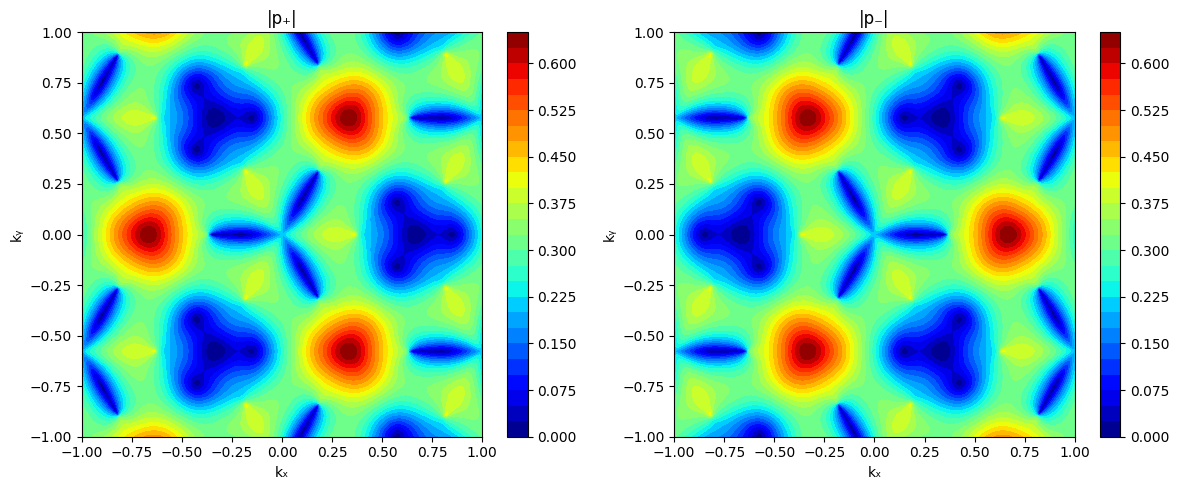

In [31]:

# --- Đọc dữ liệu từ file ---
data = []
with open('corrected tbm kx ky.txt', 'r') as f:
    for line in f:
        if line.startswith('#'):
            continue
        tokens = line.strip().split()
        kx = float(tokens[0])
        ky = float(tokens[1])
        p_plus = float(tokens[4])  # |p+| là cột thứ 5 (index 5)
        p_minus = float(tokens[5]) # |p-| là cột thứ 6 (index 6)
        data.append([kx, ky, p_plus, p_minus])

data = np.array(data)

# --- Tạo lưới kx, ky ---
kx_vals = np.unique(data[:, 0])
ky_vals = np.unique(data[:, 1])
kx_grid, ky_grid = np.meshgrid(kx_vals, ky_vals)

# --- Tạo lưới p+ và p- ---
p_plus_grid = np.zeros_like(kx_grid)
p_minus_grid = np.zeros_like(kx_grid)

for i in range(data.shape[0]):
    kx = data[i, 0]
    ky = data[i, 1]
    idx_kx = np.where(kx_vals == kx)[0][0]
    idx_ky = np.where(ky_vals == ky)[0][0]
    p_plus_grid[idx_ky, idx_kx] = data[i, 2]
    p_minus_grid[idx_ky, idx_kx] = data[i, 3]

# --- Vẽ contour ---
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# |p+|
c1 = axs[0].contourf(kx_grid, ky_grid, p_plus_grid, levels=30, cmap='jet')
axs[0].set_title('|p₊|')
axs[0].set_xlabel('kₓ')
axs[0].set_ylabel('kᵧ')
fig.colorbar(c1, ax=axs[0])

# |p-|
c2 = axs[1].contourf(kx_grid, ky_grid, p_minus_grid, levels=30, cmap='jet')
axs[1].set_title('|p₋|')
axs[1].set_xlabel('kₓ')
axs[1].set_ylabel('kᵧ')
fig.colorbar(c2, ax=axs[1])

plt.tight_layout()
plt.show()


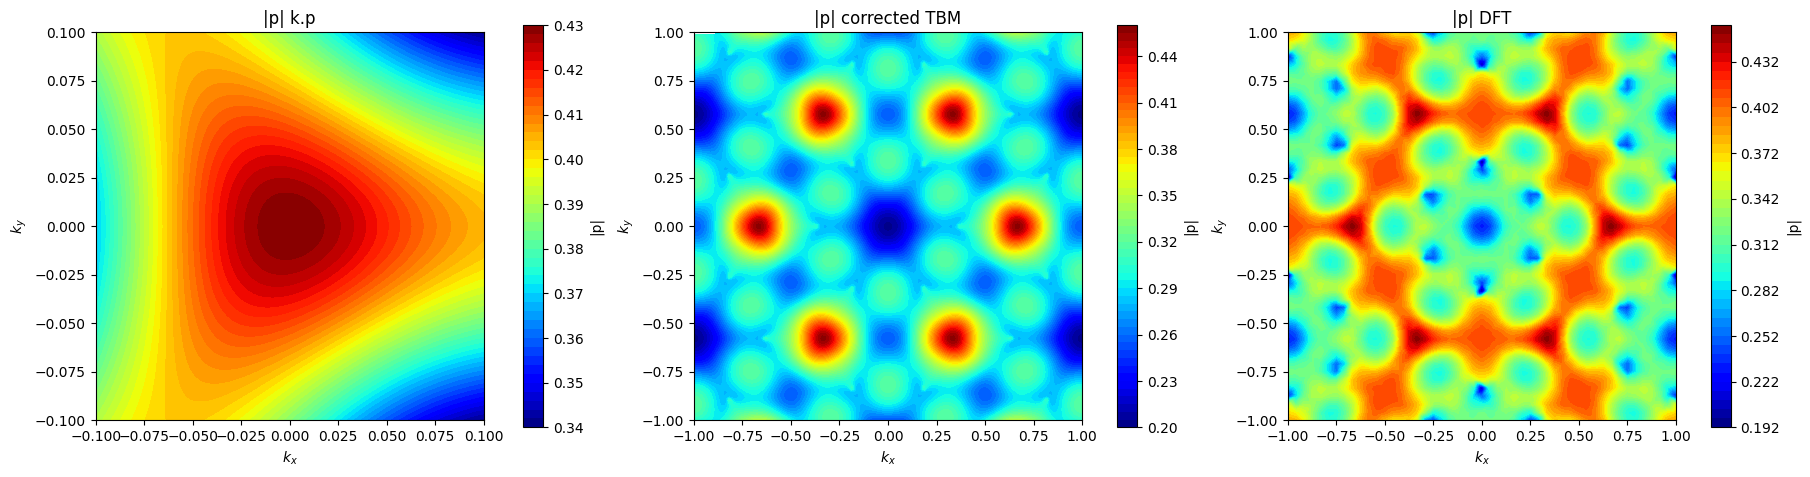

In [42]:
from scipy.interpolate import griddata

# Hàm đọc và trích giá trị theo cột cần
def read_kx_ky_val(filename, column_index):
    kx_list, ky_list, val_list = [], [], []
    with open(filename, "r") as f:
        for line in f:
            if line.strip().startswith("#") or not line.strip():
                continue
            parts = line.strip().split()
            try:
                kx = float(parts[0])
                ky = float(parts[1])
                value = float(parts[column_index])
                kx_list.append(kx)
                ky_list.append(ky)
                val_list.append(value)
            except ValueError:
                continue
    return np.array(kx_list), np.array(ky_list), np.array(val_list)

# Danh sách các file và thông tin tương ứng
files = [
    ("momentum cho kp.txt", "|p| k.p", 6),
    ("corrected tbm kx ky.txt", "|p| corrected TBM", 6),
    ("p_cv_full_294.txt", "|p| DFT", 6)
]

# Tạo subplot
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

# Vẽ từng biểu đồ
for i, (filename, title, column_index) in enumerate(files):
    kx, ky, val = read_kx_ky_val(filename, column_index=column_index)

    if len(np.unique(ky)) < 3:
        print(f"⚠️ File {filename} không đủ chiều ky để nội suy.")
        continue

    # Nội suy lên lưới đều
    kx_lin = np.linspace(kx.min(), kx.max(), 200)
    ky_lin = np.linspace(ky.min(), ky.max(), 200)
    kx_grid, ky_grid = np.meshgrid(kx_lin, ky_lin)
    val_grid = griddata((kx, ky), val, (kx_grid, ky_grid), method='linear')

    # Vẽ contour
    cp = axes[i].contourf(kx_grid, ky_grid, val_grid, levels=50, cmap='jet')
    axes[i].set_title(title)
    axes[i].set_xlabel("$k_x$")
    axes[i].set_ylabel("$k_y$")
    axes[i].set_aspect('equal')

    # Mỗi hình có một colorbar riêng
    fig.colorbar(cp, ax=axes[i], shrink=0.85, label="|p|")

plt.show()

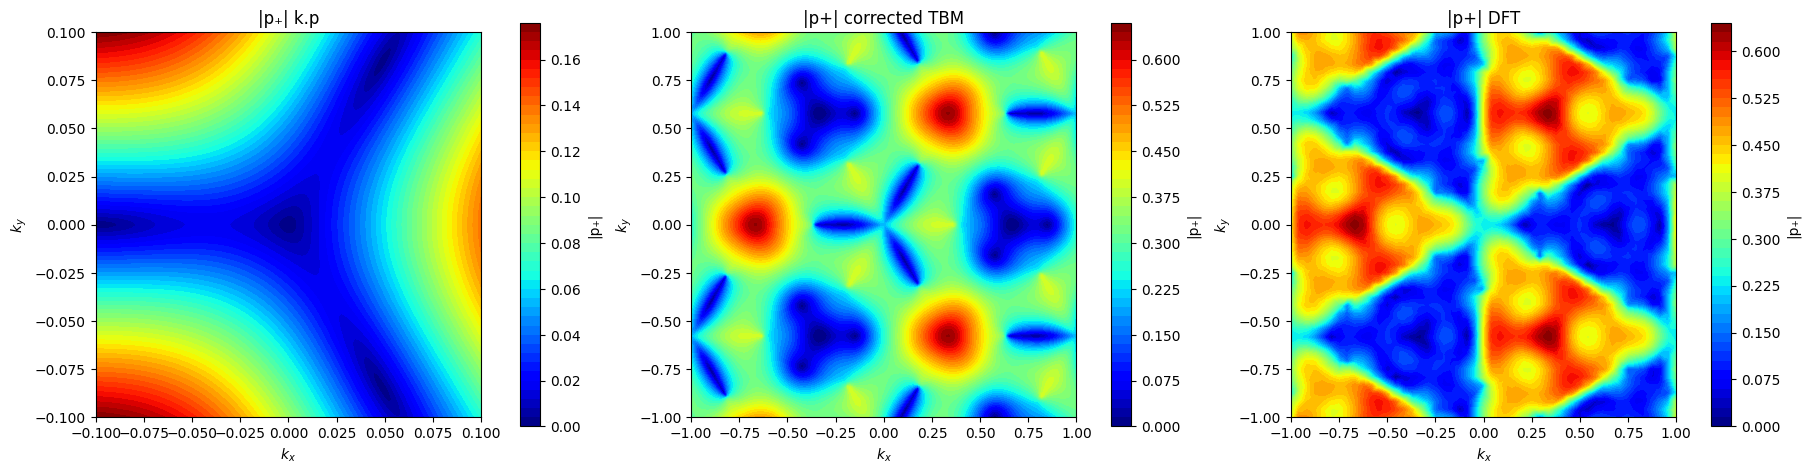

In [40]:
from scipy.interpolate import griddata

# Hàm đọc và trích giá trị theo cột cần
def read_kx_ky_val(filename, column_index):
    kx_list, ky_list, val_list = [], [], []
    with open(filename, "r") as f:
        for line in f:
            if line.strip().startswith("#") or not line.strip():
                continue
            parts = line.strip().split()
            try:
                kx = float(parts[0])
                ky = float(parts[1])
                value = float(parts[column_index])
                kx_list.append(kx)
                ky_list.append(ky)
                val_list.append(value)
            except ValueError:
                continue
    return np.array(kx_list), np.array(ky_list), np.array(val_list)

# Danh sách các file và thông tin tương ứng
files = [
    ("momentum cho kp.txt", "|p₊| k.p", 2),
    ("corrected tbm kx ky.txt", "|p+| corrected TBM", 4),
    ("p_cv_full_294.txt", "|p+| DFT", 4)
]

# Tạo subplot
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

# Vẽ từng biểu đồ
for i, (filename, title, column_index) in enumerate(files):
    kx, ky, val = read_kx_ky_val(filename, column_index=column_index)

    if len(np.unique(ky)) < 3:
        print(f"⚠️ File {filename} không đủ chiều ky để nội suy.")
        continue

    # Nội suy lên lưới đều
    kx_lin = np.linspace(kx.min(), kx.max(), 200)
    ky_lin = np.linspace(ky.min(), ky.max(), 200)
    kx_grid, ky_grid = np.meshgrid(kx_lin, ky_lin)
    val_grid = griddata((kx, ky), val, (kx_grid, ky_grid), method='linear')

    # Vẽ contour
    cp = axes[i].contourf(kx_grid, ky_grid, val_grid, levels=50, cmap='jet')
    axes[i].set_title(title)
    axes[i].set_xlabel("$k_x$")
    axes[i].set_ylabel("$k_y$")
    axes[i].set_aspect('equal')

    # Mỗi hình có một colorbar riêng
    fig.colorbar(cp, ax=axes[i], shrink=0.85, label="|p₊|")

plt.show()

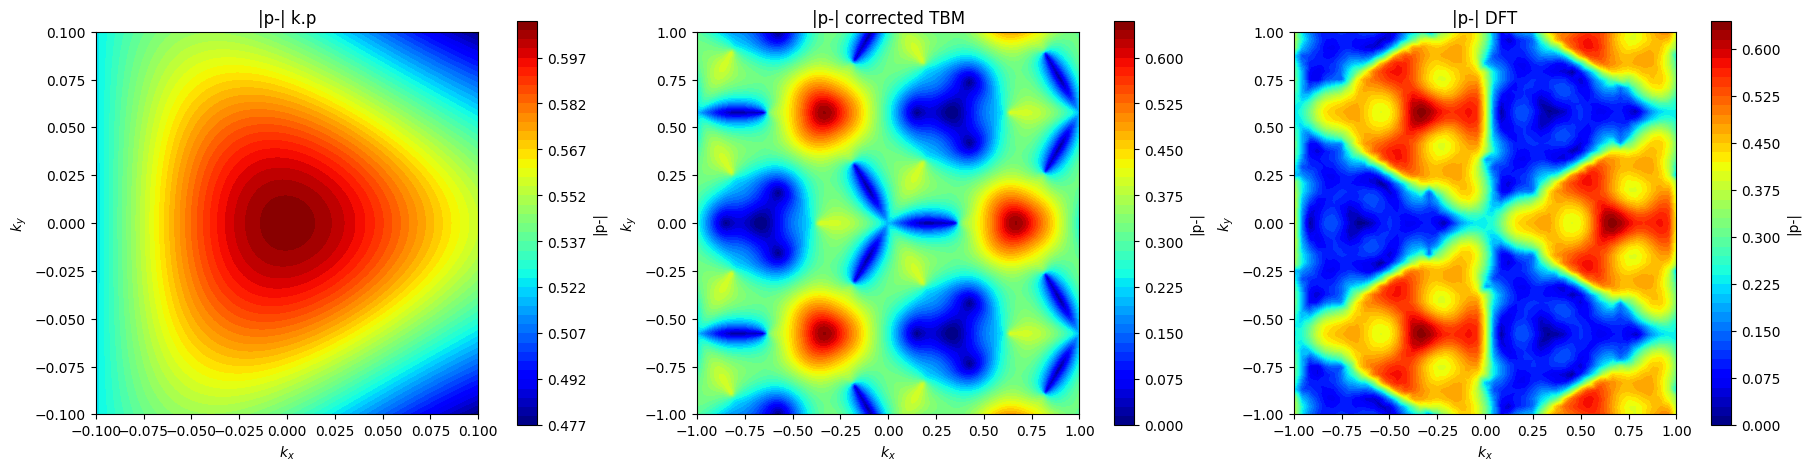

In [41]:
from scipy.interpolate import griddata

# Hàm đọc và trích giá trị theo cột cần
def read_kx_ky_val(filename, column_index):
    kx_list, ky_list, val_list = [], [], []
    with open(filename, "r") as f:
        for line in f:
            if line.strip().startswith("#") or not line.strip():
                continue
            parts = line.strip().split()
            try:
                kx = float(parts[0])
                ky = float(parts[1])
                value = float(parts[column_index])
                kx_list.append(kx)
                ky_list.append(ky)
                val_list.append(value)
            except ValueError:
                continue
    return np.array(kx_list), np.array(ky_list), np.array(val_list)

# Danh sách các file và thông tin tương ứng
files = [
    ("momentum cho kp.txt", "|p-| k.p", 3),
    ("corrected tbm kx ky.txt", "|p-| corrected TBM", 5),
    ("p_cv_full_294.txt", "|p-| DFT", 5)
]

# Tạo subplot
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

# Vẽ từng biểu đồ
for i, (filename, title, column_index) in enumerate(files):
    kx, ky, val = read_kx_ky_val(filename, column_index=column_index)

    if len(np.unique(ky)) < 3:
        print(f"⚠️ File {filename} không đủ chiều ky để nội suy.")
        continue

    # Nội suy lên lưới đều
    kx_lin = np.linspace(kx.min(), kx.max(), 200)
    ky_lin = np.linspace(ky.min(), ky.max(), 200)
    kx_grid, ky_grid = np.meshgrid(kx_lin, ky_lin)
    val_grid = griddata((kx, ky), val, (kx_grid, ky_grid), method='linear')

    # Vẽ contour
    cp = axes[i].contourf(kx_grid, ky_grid, val_grid, levels=50, cmap='jet')
    axes[i].set_title(title)
    axes[i].set_xlabel("$k_x$")
    axes[i].set_ylabel("$k_y$")
    axes[i].set_aspect('equal')

    # Mỗi hình có một colorbar riêng
    fig.colorbar(cp, ax=axes[i], shrink=0.85, label="|p-|")

plt.show()

The last block is used for comparing the dispersion curves of |p| along kx with DFT, old TBM and new calculated TBM.

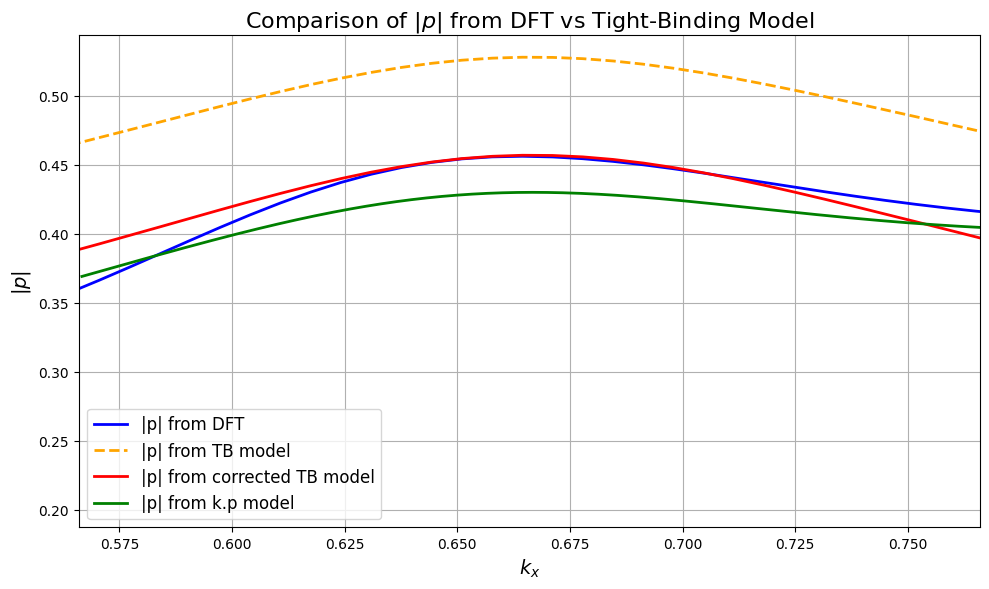

In [ ]:
# Đọc file 1 (DFT)
df1 = pd.read_csv('p_cv_abs_294.txt', sep='\s+', comment='#')
df1['p_abs'] = pd.to_numeric(df1['p_abs'], errors='coerce')

col_names2 = ['kx', 'ky', 'px', 'py', 'p_plus', 'p_minus', 'p_abs']
df2 = pd.read_csv(
    'momentum cho tb val_cond with kx.txt',
    sep='\s+',
    comment='#',
    names=col_names2
)

# ✅ Loại bỏ các dòng trùng lặp theo kx
df2 = df2.drop_duplicates(subset='kx', keep='first')

# ✅ Hoặc chỉ giữ lại 300 dòng đầu (nếu bạn biết đó là đúng)
df2 = df2.iloc[:300]

col_names3 = ['kx', 'ky', 'px', 'py', 'p_plus', 'p_minus', 'p_abs']
df3 = pd.read_csv(
    'corrected tbm kx.txt',
    sep='\s+',
    comment='#',
    names=col_names3
)

# ✅ Loại bỏ các dòng trùng lặp theo kx
df3 = df3.drop_duplicates(subset='kx', keep='first')

# ✅ Hoặc chỉ giữ lại 300 dòng đầu (nếu bạn biết đó là đúng)
df3 = df3.iloc[:300]

col_names = ['kx', 'ky', 'p_plus', 'p_minus', 'px', 'py', 'p_abs']

df4 = pd.read_csv(
    'momentum cho kp.txt',
    sep='\s+',
    comment='#',
    names=col_names
)

# ✅ Nếu bạn muốn loại bỏ trùng lặp theo kx:
df4 = df4.drop_duplicates(subset='kx', keep='first')
df4['kx'] += 2.0 / 3.0
# ✅ Hoặc chỉ giữ 300 dòng đầu:
df4 = df4.iloc[:300]

# Vẽ so sánh
plt.figure(figsize=(10, 6))
plt.plot(df1['kx'], df1['p_abs'], label='|p| from DFT', color='blue', linewidth=2)
plt.plot(df2['kx'], df2['p_abs'], label='|p| from TB model', color='orange', linewidth=2, linestyle='--')
plt.plot(df3['kx'], df3['p_abs'], label='|p| from corrected TB model', color='red', linewidth=2, linestyle='-')
plt.plot(df4['kx'], df4['p_abs'], label='|p| from k.p model', color='green', linewidth=2)

plt.xlim(0.566, 0.766)
plt.xlabel('$k_x$', fontsize=14)
plt.ylabel('$|p|$', fontsize=14)
plt.title('Comparison of $|p|$ from DFT vs Tight-Binding Model', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
